In [1]:
import pandas as pd
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve,RepeatedKFold

from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from imblearn import over_sampling as ovs
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,quantile_transform,PowerTransformer

%matplotlib inline

In [2]:
sns.set_context(context="paper")
def learn_curves(estimator, features, target, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, features, target,train_sizes = np.linspace(.1, 1.0, 10),
                                                 cv = cv, scoring = 'r2',n_jobs=-1)
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    
    plt.plot(train_sizes, np.sqrt(train_scores_mean), label = 'Training error')
    plt.plot(train_sizes, np.sqrt(validation_scores_mean), label = 'Validation error')

    plt.ylabel('R2', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curve'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(-1,3)

In [40]:
df_final = pd.read_csv("../data/DF_contact15_energy_sasa.Zero.csv",index_col=0)
df_final.shape

(645, 71)

In [3]:

#dataframe final
df_final = pd.read_csv("../data/DF_contact15_energy_sasa.Zero.csv",index_col=0)

index_ddg8 = (df_final['ddG_exp']>6.3)
df_final = df_final.loc[-index_ddg8]
#testiar eliminando estructuras con ddg menor o igual a -4 kcal/mol , outliers
index_ddg_4 =  (df_final['ddG_exp'] <= -4)
df_final = df_final.loc[-index_ddg_4]

# Quitar modelos por homologia deltraining set
df_final= df_final.loc[~df_final.index.str.startswith("HM")]

pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns


1AK4.mut.0_Repair.clean.pdb      2.49
1AK4.mut.1_Repair.clean.pdb      0.60
1AK4.mut.2_Repair.clean.pdb      0.41
1AK4.mut.3_Repair.clean.pdb      0.19
1AK4.mut.4_Repair.clean.pdb      1.91
1AK4.mut.5_Repair.clean.pdb      2.86
1AK4.mut.6_Repair.clean.pdb      0.84
1AK4.mut.7_Repair.clean.pdb      0.80
1AK4.mut.8_Repair.clean.pdb      1.48
1AK4.mut.9_Repair.clean.pdb      0.07
1AK4.mut.10_Repair.clean.pdb    -0.17
1AK4.mut.11_Repair.clean.pdb     0.92
1AK4.mut.12_Repair.clean.pdb     2.00
1AK4.mut.13_Repair.clean.pdb     2.86
1AK4.mut.14_Repair.clean.pdb     0.51
1AK4.mut.15_Repair.clean.pdb     0.82
1BJ1.mut.16_Repair.clean.pdb    -0.00
1BJ1.mut.17_Repair.clean.pdb    -0.00
1BJ1.mut.18_Repair.clean.pdb     0.82
1BJ1.mut.19_Repair.clean.pdb     2.76
1BJ1.mut.20_Repair.clean.pdb     3.69
1BJ1.mut.21_Repair.clean.pdb    -0.00
1BJ1.mut.22_Repair.clean.pdb    -0.00
1BJ1.mut.23_Repair.clean.pdb     0.82
1BJ1.mut.24_Repair.clean.pdb     3.69
1BJ1.mut.25_Repair.clean.pdb     0.41
1BJ1.mut.26_

In [36]:
df_final.index

Index(['1AK4.mut.0_Repair.clean.pdb', '1AK4.mut.1_Repair.clean.pdb',
       '1AK4.mut.2_Repair.clean.pdb', '1AK4.mut.3_Repair.clean.pdb',
       '1AK4.mut.4_Repair.clean.pdb', '1AK4.mut.5_Repair.clean.pdb',
       '1AK4.mut.6_Repair.clean.pdb', '1AK4.mut.7_Repair.clean.pdb',
       '1AK4.mut.8_Repair.clean.pdb', '1AK4.mut.9_Repair.clean.pdb',
       ...
       '3NPS.mut.548_Repair.clean.pdb', '3NPS.mut.549_Repair.clean.pdb',
       '3NPS.mut.550_Repair.clean.pdb', '3NPS.mut.551_Repair.clean.pdb',
       '3NPS.mut.552_Repair.clean.pdb', '3NPS.mut.553_Repair.clean.pdb',
       '3NPS.mut.554_Repair.clean.pdb', '3NPS.mut.555_Repair.clean.pdb',
       '3NPS.mut.556_Repair.clean.pdb', '3NPS.mut.557_Repair.clean.pdb'],
      dtype='object', length=531)

In [38]:
import math
def deltaG_to_Kd(delg):
    Kd_value = math.exp((delg*1000)/(1.98*298.15))
    return Kd_value

In [39]:
#X = df_final_f1 # con filtrado de varianza
X = df_final.drop('ddG_exp',axis=1).astype(float)
y = df_final['ddG_exp']

In [40]:
# binned split
bins = np.linspace(0, len(X), 50)
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned,random_state=1)                                                    

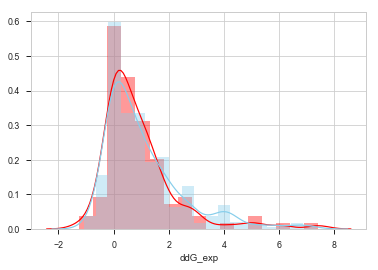

In [41]:
sns.distplot( y_test , color="red", label="ddG_exp_test")
sns.distplot( y_train , color="skyblue", label="ddG_exp_train")

In [139]:
max_depth 1 - 2, maxleafnodes 2-7-12, min_samples_spli 200-205,min_samples_leaf 20-40, max features 21 -37

SyntaxError: invalid syntax (<ipython-input-139-3be8a706e74a>, line 1)

In [9]:
RandomForestRegressor?

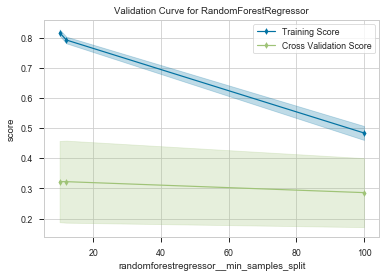

In [51]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
selector = VarianceThreshold()

#2)
rf_model = RandomForestRegressor(random_state=1212,n_estimators=100)
#3) Crear pipeline
pipeline1 = make_pipeline(selector,rf_model)
cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13)

# Extract the instances and target
viz = ValidationCurve(
    pipeline1, njobs=-1,param_name="randomforestregressor__min_samples_split",
    param_range=[10,12,100], cv=cv, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()


In [52]:
#1)
selector = VarianceThreshold()
#2)
rf_model = RandomForestRegressor(random_state=1212)
#3) Crear pipeline
pipeline1 = make_pipeline(selector,rf_model)
# grid params
param_grid = {
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__max_depth': [None],
    'randomforestregressor__max_features': ['sqrt'],
    'randomforestregressor__max_leaf_nodes':[None],
    'randomforestregressor__min_samples_leaf': [8],
    'randomforestregressor__min_samples_split': [100],
    'randomforestregressor__n_estimators': [60],
    'randomforestregressor__random_state':[1212],
    }
cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid1 = GridSearchCV(pipeline1, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)

grid1.fit(X_train,y_train)

Fitting 50 folds for each of 1 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  50 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    3.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a19076358>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurit...='warn', n_jobs=None,
           oob_score=False, random_state=1212, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'randomforestregressor__bootstrap': [True], 'randomforestregressor__max_depth': [None], 'randomforestregressor__max_features': ['sqrt'], 'randomforestregressor__max_leaf_nodes': [None], 'randomforestregressor__min_samples_leaf': [8], 'randomforestregressor__min_samples_split': [100], 'randomforestregressor__n_estimators': [60], 'randomforestregressor__random_state': [1212]},
       pre_dispat

In [53]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',grid1.score(X_test,y_test))
print('R2 train',grid1.score(X_train,y_train))

CV test RMSE 1.254372 +/- 0.659462
CV train RMSE 1.167839 +/- 0.278958
CV test r2 0.231477 +/- 0.059670
CV train r2 0.345364 +/- 0.021094
0.11388752948243636
 {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__min_samples_leaf': 8, 'randomforestregressor__min_samples_split': 100, 'randomforestregressor__n_estimators': 60, 'randomforestregressor__random_state': 1212}

RMSE for test dataset: 1.24
RMSE for train dataset: 1.14
pearson corr  0.435258
R2 test 0.16251424813792703
R2 train 0.3817064484090632


In [24]:
CV test RMSE 1.026842 +/- 0.460995
CV train RMSE 0.846851 +/- 0.174561
CV test r2 0.392922 +/- 0.065468
CV train r2 0.591016 +/- 0.010930
0.1980940986494878
 {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__min_samples_leaf': 8, 'randomforestregressor__min_samples_split': 20, 'randomforestregressor__n_estimators': 300, 'randomforestregressor__random_state': 1212}

RMSE for test dataset: 1.03
RMSE for train dataset: 0.83
pearson corr  0.607642
R2 test 0.3502035154202203
R2 train 0.6108388822062347

Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=1212, verbose=0, warm_start=False))])

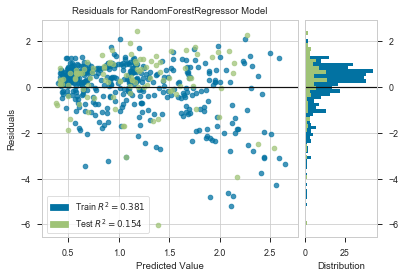

In [44]:
visualizer = ResidualsPlot(grid1.best_estimator_)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

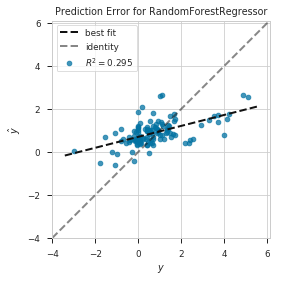

In [70]:
perror = PredictionError(grid1.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof() 

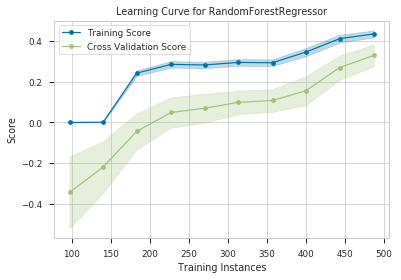

In [71]:
viz = LearningCurve(grid1.best_estimator_, cv=cv, n_jobs=-1,scoring='r2',train_sizes=np.linspace(0.2, 1.0, 10))
viz.fit(X, y)
#plt.ylim(0,-4)
viz.poof()

In [72]:
final_rf = grid1.best_estimator_.fit(X,y)

In [73]:
# save final model

joblib.dump(final_rf, 'RFmodel_contact15energy_sasa_Zero.pkl')

['RFmodel_contact15energy_sasa_Zero.pkl']

# mismo modelo, ahora con smote 

In [18]:
# forma 1
df_final['class'] = np.where((df_final['ddG_exp'] < -0.4) | (df_final['ddG_exp'] > 1),0,1)
# forma 2 
#df_final['class'] = np.where((df_final['ddG_exp'] < -0.4),1,0)

In [19]:
print("Before OverSampling, counts of label '1': {}".format(sum(df_final['class'] == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(df_final['class'] == 0)))

Before OverSampling, counts of label '1': 355
Before OverSampling, counts of label '0': 254


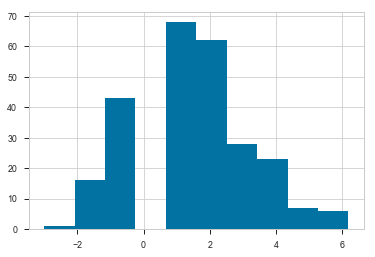

In [20]:
df_final.loc[df_final['class'] == 0]['ddG_exp'].hist()

In [21]:
X = df_final.drop('class',axis=1)
y = df_final['class']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y,train_size=0.8,random_state=1212)


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [23]:
#smote = ovs.SMOTE(random_state=1212,m_neighbors=10)
smote = ovs.BorderlineSMOTE(random_state=1212,m_neighbors=12,kind='borderline-1')
#adasyn = ovs.ADASYN(random_state=1212,n_neighbors=10)
#X_train_re , y_train_re = adasyn.fit_sample(X_train,y_train)
X_train_re , y_train_re = smote.fit_sample(X_train,y_train)

In [24]:
# back to originalk shape and target
X_train_normal = X_train_re[:,:-1]
y_train_normal = X_train_re[:,-5]

X_test_normal = X_test.iloc[:,:-1]
y_test_normal = X_test.iloc[:,-5]

In [34]:
X_train_re[:,-5]

array([-0.08      , -0.05      , -0.52      , -0.06      , -0.06      ,
        1.2       ,  2.16      ,  5.22      ,  0.1       ,  1.3       ,
        1.57      , -0.2       ,  1.78      , -0.        ,  0.75      ,
       -0.        ,  0.24      ,  1.4       ,  1.17      ,  2.        ,
       -0.2       ,  1.75      ,  1.17      , -0.2       ,  0.02      ,
        1.05      ,  0.2       , -0.15      ,  0.5       , -0.        ,
       -0.        , -0.3       ,  0.1       ,  0.6       ,  0.68      ,
        0.84      , -0.        ,  0.07      , -0.4       ,  0.17      ,
        2.73      ,  1.06      , -0.34      , -1.33      ,  0.66      ,
        3.69      , -0.06      ,  0.03      ,  2.5       ,  2.73      ,
        2.5       ,  0.22      , -0.58      ,  2.08      ,  0.6       ,
        1.1       , -0.2       , -0.07      ,  0.26      , -0.54      ,
        0.96      ,  0.82      ,  0.56      ,  4.4       , -0.7       ,
        1.        , -0.16      , -0.3       , -0.4       ,  0.53

In [25]:
model = grid1.best_estimator_.fit(X_train_normal,y_train_normal)
#print('CV test RMSE',np.sqrt(-grid.best_score_))
#print('CV train RMSE',np.sqrt(-grid.cv_results_['mean_train_score'].max()))

y_test_pred = model.predict(X_test_normal.values)
y_train_pred = model.predict(X_train_normal)

print('Training score (r2): {}'.format(r2_score(y_train_normal, y_train_pred)))
print('Test score (r2): {}'.format(r2_score(y_test_normal.values, y_test_pred)))

print("\nRoot mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test_normal.values, y_test_pred)), 2)))
print("Root mean square error for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train_normal, y_train_pred)), 2)))
print("pearson corr: ",np.corrcoef(y_test_pred,y_test_normal.values)[0][1])

Training score (r2): 0.9929978413287694
Test score (r2): 0.9901959175563946

Root mean square error for test dataset: 2094.28
Root mean square error for train dataset: 1897.76
pearson corr:  0.9968148846145848


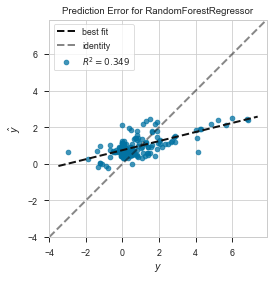

In [140]:
perror = PredictionError(model)

perror.fit(X_train_normal, y_train_normal)  # Fit the training data to the visualizer
perror.score(X_test_normal.values, y_test_normal.values)  # Evaluate the model on the test data
g = perror.poof()

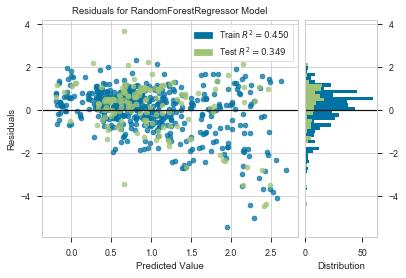

In [141]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_normal, y_train_normal)  # Fit the training data to the model
visualizer.score(X_test_normal.values, y_test_normal.values)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


## Salvar modelo final, entrenado con el total de lso datos

In [115]:
ABPRED_DIR = Path().cwd().parent
DATA = ABPRED_DIR / "data"

#dataframe final
df_final = pd.read_csv(DATA/"../data/DF_features_400_2019.csv",index_col=0)
# Quitar modelos por homologia deltraining set
#df_final_onlyHM = df_final.loc[df_final.index.str.startswith("HM")]
#df_final= df_final.loc[~df_final.index.str.startswith("HM")]

index_ddg8 = (df_final['ddG(kcal/mol)']==8)
df_final = df_final.loc[-index_ddg8]
#testiar eliminando estructuras con ddg menor o igual a -4 kcal/mol , outliers
index_ddg_4 =  (df_final['ddG(kcal/mol)'] <= -4)
df_final = df_final.loc[-index_ddg_4]


pdb_names = df_final.index
features_names = df_final.drop('ddG(kcal/mol)',axis=1).columns

In [42]:
# forma 1
#df_final['class'] = np.where((df_final['ddG(kcal/mol)'] < -0.4) | (df_final['ddG(kcal/mol)'] > 2.4),0,1)
# forma 2 
df_final['class'] = np.where((df_final['ddG(kcal/mol)'] < 0),1,0)

In [43]:
print("Before OverSampling, counts of label '1': {}".format(sum(df_final['class'] == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(df_final['class'] == 0)))

Before OverSampling, counts of label '1': 481
Before OverSampling, counts of label '0': 134


In [44]:
X = df_final.drop('class',axis=1)
y = df_final['class']

In [45]:
smote = ovs.SMOTE(random_state=12,m_neighbors=25)
X_re , y__re = smote.fit_sample(X,y)

In [46]:
# back to originalk shape and target
X_normal = X_re[:,:-1]
y_normal = X_re[:,-1]

In [47]:
final_rf = grid1.best_estimator_.fit(X_normal,y_normal)

In [48]:
# save final model

joblib.dump(final_rf, 'RFmodel_400.smote.v1.pkl')

['RFmodel_400.smote.v1.pkl']

/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(4.5,-0.5,'RMSE = 1.017')

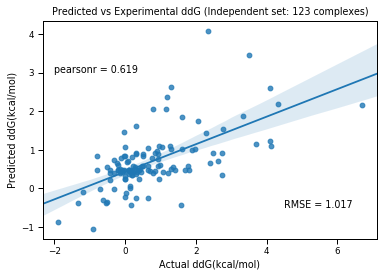

In [12]:
rmse_test = np.round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 3)
df_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_pred_test, "Actual ddG(kcal/mol)": y_test.values})
pearsonr_test = round(df_pred.corr().iloc[0,1],3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_pred)
plt.title("Predicted vs Experimental ddG (Independent set: 123 complexes)")

plt.text(-2,3,"pearsonr = %s" %pearsonr_test)
plt.text(4.5,-0.5,"RMSE = %s" %rmse_test)

#plt.savefig("RFmodel_300_testfit.png",dpi=600)

/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Predicted vs Experimental ddG (Train set: 492 complexes)')

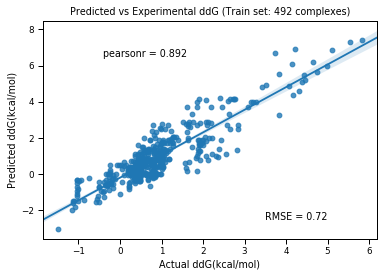

In [13]:
df_train_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_train, "Actual ddG(kcal/mol)": y_pred_train})
pearsonr_train = round(df_train_pred.corr().iloc[0,1],3)
rmse_train = np.round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_train_pred)

plt.text(-0.4,6.5,"pearsonr = %s" %pearsonr_train)
plt.text(3.5,-2.5,"RMSE = %s" %rmse_train)
plt.title("Predicted vs Experimental ddG (Train set: 492 complexes)")
#plt.savefig("RFmodel_300_trainfit.png",dpi=600)


In [52]:
rf_model = grid1.best_estimator_.named_steps["randomforestregressor"]
importances = list(rf_model.feature_importances_)
feature_list = df_final.columns
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: dg_change            Importance: 0.1173
Variable: hydrophobic          Importance: 0.0681
Variable: solvation_hydrophobic_change Importance: 0.0512
Variable: interface_residues_bb_clashing_wt Importance: 0.0395
Variable: torsional_clash_wt   Importance: 0.0394
Variable: sasa_total_mut       Importance: 0.034
Variable: backbone_clash_wt    Importance: 0.0338
Variable: if_total             Importance: 0.0335
Variable: dg_wt                Importance: 0.031
Variable: backbone_hbond_change Importance: 0.0294
Variable: van_der_waals_change Importance: 0.0291
Variable: number_of_residues_x Importance: 0.0263
Variable: electrostatics_wt    Importance: 0.026
Variable: energy_ionisation_wt Importance: 0.0258
Variable: interface_residues_vdw_clashing_wt Importance: 0.0239
Variable: van_der_waals_clashes_change Importance: 0.0233
Variable: van_der_waals_clashes_wt Importance: 0.0192
Variable: entropy_complex_wt   Importance: 0.0185
Variable: sasa_phob_mut        Importance: 0.0184
Varia

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 0, 'Feature importance')

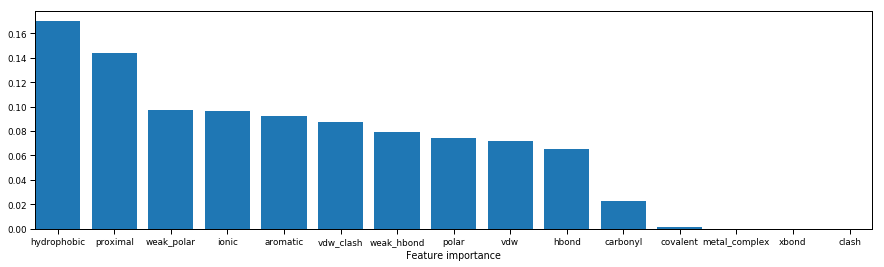

In [23]:
idx_features = model.feature_importances_.argsort()[::-1]
plt.figure(figsize=(15,4))

plt.bar(np.arange(X_train.shape[1]), model.feature_importances_[idx_features])
plt.xticks(range(len(feature_list)),feature_list[idx_features])
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel(u"Feature importance")
#plt.savefig("RFmodel_300_50features",dpi=600,bbox_inches="tight")

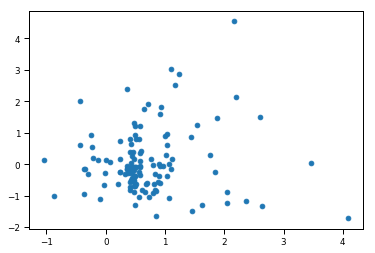

In [15]:
residual = y_test.values - y_pred_test
plt.scatter(x=y_pred_test.T, y=residual.T)

In [16]:
from sklearn.model_selection import learning_curve
def learning_curves(estimator, features, target, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, features, target,train_sizes = np.linspace(.1, 1.0, 10),
                                                 cv = cv, scoring = 'neg_mean_squared_error',n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    
    plt.plot(train_sizes, np.sqrt(train_scores_mean), label = 'Training error')
    plt.plot(train_sizes, np.sqrt(validation_scores_mean), label = 'Validation error')

    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curve'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,3)

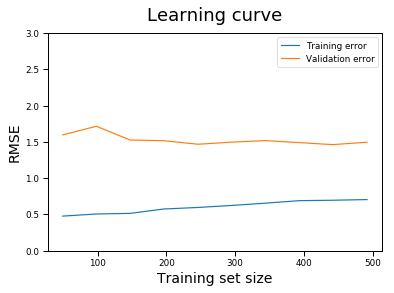

In [17]:
learning_curves(model,X,y,5)
#plt.savefig("RFmodel_300_learnincurve.png",dpi=600,bbox_inches="tight")

# Manuall CV with smote

In [127]:
# forma 1
df_final['class'] = np.where((df_final['ddG_exp'] < -0.4) | (df_final['ddG_exp'] > 2.4),0,1)
# forma 2 
#df_final['class'] = np.where((df_final['ddG_exp'] < 0),1,0)

In [128]:
print("Before OverSampling, counts of label '1': {}".format(sum(df_final['class'] == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(df_final['class'] == 0)))

Before OverSampling, counts of label '1': 481
Before OverSampling, counts of label '0': 134


In [129]:
X = df_final.drop('class',axis=1)
y = df_final['class']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y,train_size=0.70,random_state=1212)


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [131]:
RandomForestRegressor?

In [ ]:
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 2, 'randomforestregressor__max_features': 37, 'randomforestregressor__max_leaf_nodes': 12, 'randomforestregressor__min_samples_leaf': 10, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 1212}

In [132]:
cv_splits = 10

cv_test_mse = np.zeros(cv_splits)
cv_test_r2 = np.zeros(cv_splits)
cv_train_mse = np.zeros(cv_splits)
cv_train_r2 = np.zeros(cv_splits)

kf = KFold(n_splits=cv_splits,random_state=1212)
#kf = StratifiedKFold(n_splits=cv_splits,random_state=12)
for i,(train_index, validation_index) in enumerate(kf.split(X_train,y_train)):
    
    X_train_cv, X_validation_cv = X_train.values[train_index], X_train.values[validation_index]
    y_train_cv, y_validation_cv = y_train.values[train_index], y_train.values[validation_index]
    
    # Oversampling
    smote = ovs.SMOTE(random_state=1212,m_neighbors=25)
    #smote = ovs.BorderlineSMOTE(random_state=12,m_neighbors=40,kind='borderline-1')
    #adasyn = ovs.ADASYN(random_state=12,n_neighbors=40)
    #X_train_ovs , y_train_ovs = adasyn.fit_sample(X_train_cv,y_train_cv)
    X_train_ovs , y_train_ovs = smote.fit_sample(X_train_cv,y_train_cv)
    
    # Back to normal dataset
    X_train_normal = X_train_ovs[:,:-1]
    y_train_normal = X_train_ovs[:,-1]
    
    X_validation_normal = X_validation_cv[:,:-1]
    y_validation_normal = X_validation_cv[:,-1]
    
    
    # Model
    model = RandomForestRegressor(n_estimators=50,max_depth=2,max_features=30,max_leaf_nodes=10,
                                  min_samples_leaf=2,min_samples_split=10,random_state=1212)
    model.fit(X_train_normal,y_train_normal)
    
    # Test
    y_test_pred = model.predict(X_validation_normal)
    y_train_pred = model.predict(X_train_normal)
    
    # Scoring
    
    test_mse = mean_squared_error(y_validation_normal,y_test_pred)
    test_r2 = r2_score(y_validation_normal,y_test_pred)
    cv_test_mse[i] = test_mse
    cv_test_r2[i] = test_r2
    
    train_mse = mean_squared_error(y_train_normal,y_train_pred)
    train_r2 = r2_score(y_train_normal,y_train_pred)
    cv_train_mse[i] = train_mse
    cv_train_r2[i] = train_r2
    
print("Test scores")
print("RMSE",np.sqrt(cv_test_mse.mean()))
print("r2",cv_test_r2.mean())
print("")
print("Train scores")
print("RMSE",np.sqrt(cv_train_mse.mean()))
print("r2",cv_train_r2.mean())


Test scores
RMSE 1.1960745680680778
r2 0.30202439829554173

Train scores
RMSE 1.1520470964345404
r2 0.5917545697264857
